## TODO:
- implement alternating minimization scheme: gctr_v, gctr_w
- implement search for multiple pairs

In [1]:
import numpy as np
import scipy.optimize
import scipy.io as sio
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
from gca import phi_f, phi_r, gc_block_covariance, nlcv, nlcw, gca_obj

## Bring in synthetic VAR data

In [2]:
import scipy
x = scipy.io.loadmat('../Xtest3.mat')['x']
stats = scipy.io.loadmat('../Xtest3.mat')['stats']
xr = np.flipud(x)

A = stats['A'][0][0]
D=4
L=3

In [3]:
blkR1, Rtilde = gc_block_covariance(x,L) # forward time
blkR1r, Rtilder = gc_block_covariance(xr,L) # reverse time

## Evaluate GCA objective with ground-truth spatial filters
s1 is the driving signal (recovered by wtrue)
s2 is the driven signal (recovered by vtrue)

In [4]:
pinvA=np.linalg.pinv(A.T)
wtrue=pinvA[:,0]
vtrue=pinvA[:,1]
x_gt=np.concatenate( ( vtrue , wtrue ) ,axis=0 )

In [5]:
gca_obj(x_gt, blkR1, Rtilde, blkR1r, Rtilder)

array([[-0.12002387]])

## Prepare non-linear unit-norm constraint for GCA optimization

In [6]:
#nlcv = scipy.optimize.NonlinearConstraint(lambda x: x.T@x, 1, 1)
#nlcw = scipy.optimize.NonlinearConstraint(lambda x: x.T@x, 1, 1)

con1 = scipy.optimize.NonlinearConstraint(nlcv, 1, 1)
con2 = scipy.optimize.NonlinearConstraint(nlcw, 1, 1)

## Run the GCA optimizer

In [7]:
optres = minimize(gca_obj, 0.01*np.random.randn(2*D,), args=( (blkR1,Rtilde,blkR1r,Rtilder) ) , method='trust-constr', constraints=[scipy.optimize.NonlinearConstraint(nlcv, 1, 1),scipy.optimize.NonlinearConstraint(nlcw, 1, 1)])

/Users/jacekdmochowski/miniconda3/envs/james_tf/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/Users/jacekdmochowski/miniconda3/envs/james_tf/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [8]:
gca_obj(optres.x,blkR1,Rtilde,blkR1r,Rtilder)

array([[-0.12084052]])

In [9]:
vstar=optres.x[0:D]
wstar=optres.x[D:2*D+1]

<StemContainer object of 3 artists>

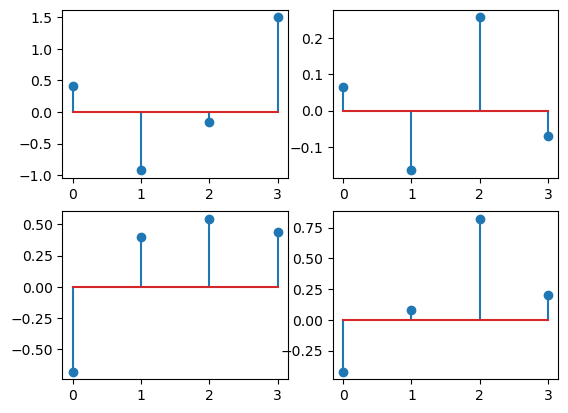

In [10]:
fig, ax = plt.subplots(2,2)
ax[0,0].stem(vtrue)
ax[0,1].stem(vstar)
ax[1,0].stem(wtrue)
ax[1,1].stem(wstar)

In [11]:
wstar.T@A, wtrue.T@A

(array([0.77974089, 0.00796858, 0.01509986]),
 array([1.00000000e+00, 2.45775074e-16, 2.26972804e-16]))

In [12]:
vstar.T@A, vtrue.T@A

(array([-0.0003691 ,  0.00925121, -0.00039535]),
 array([ 1.18650568e-16,  1.00000000e+00, -1.48052910e-16]))

Code for generating VAR data is below

In [13]:
#B = np.array([[0.9, 0], [-0.2, 0.8]])

#D=x.shape[0] # of sensors
#M=2 # of sources
#L=1 # max lag of AR model
#T=50000 # of time samples
#noisepwr=1
#A = np.random.rand(D,M) # mixing matrix
#sensornoisepwr=0.1

# latent sources
#s = np.zeros(shape=(M,T))
#s[:,0:L] = np.random.randn(M,L)
#sinn = noisepwr*np.random.randn(M,T)

In [14]:
#for t in range(L,T):
#    s[:,t] = B@s[:,t-1] + sinn[:,t]
#x = A@s + sensornoisepwr*np.random.randn(D,T)